In [2]:
!pip install gymnasium
!pip install scikit-learn
!pip install matplotlib
!pip install pandas
!pip install numpy


In [3]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor


In [4]:
env = gym.make("CartPole-v1")
obs, info = env.reset()

print("Initial Observation:", obs)
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)


Initial Observation: [ 0.04670623 -0.01988349  0.03837411  0.02057333]
Observation Space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action Space: Discrete(2)


In [5]:
# Parameter bounds (manually chosen realistic bounds)
BOUNDS = {
    "cart_position": (-2.4, 2.4),
    "cart_velocity": (-3.0, 3.0),
    "pole_angle": (-0.2, 0.2),
    "pole_angular_velocity": (-3.0, 3.0)
}


In [6]:
def generate_random_state():
    return np.array([
        np.random.uniform(*BOUNDS["cart_position"]),
        np.random.uniform(*BOUNDS["cart_velocity"]),
        np.random.uniform(*BOUNDS["pole_angle"]),
        np.random.uniform(*BOUNDS["pole_angular_velocity"])
    ])


In [7]:
def run_simulation(initial_state):
    env = gym.make("CartPole-v1")
    env.reset()
    env.unwrapped.state = initial_state

    total_reward = 0

    for _ in range(200):
        action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
        if done:
            break

    return total_reward


In [8]:
simulation_data = []

for i in range(1000):
    state = generate_random_state()
    reward = run_simulation(state)
    simulation_data.append([
        state[0], state[1], state[2], state[3], reward
    ])

df = pd.DataFrame(simulation_data, columns=[
    "cart_position",
    "cart_velocity",
    "pole_angle",
    "pole_angular_velocity",
    "reward"
])

df.head()


,cart_position,cart_velocity,pole_angle,pole_angular_velocity,reward
0,-1.042473,2.619700,0.199573,1.999414,1.0
1,0.728814,0.106368,0.061607,-1.573352,14.0
2,-0.034523,0.542351,-0.051508,-1.389423,6.0
3,-0.832191,-0.529009,0.184248,-0.486048,24.0
4,0.231927,-2.680032,0.102608,1.133239,34.0


In [9]:
df.describe()


,cart_position,cart_velocity,pole_angle,pole_angular_velocity,reward
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.007859,-0.012616,-0.001392,-0.044495,10.706000
std,1.377458,1.728625,0.117003,1.699366,10.711597
min,-2.399090,-2.998766,-0.199563,-2.997233,1.000000
25%,-1.198078,-1.502419,-0.105174,-1.438419,4.000000
50%,-0.053860,-0.052309,-0.000222,-0.038683,7.000000
75%,1.221041,1.431362,0.100839,1.399097,13.000000
max,2.395954,2.997399,0.199573,2.994095,87.000000


In [10]:
X = df.drop("reward", axis=1)
y = df["reward"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [11]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Support Vector Regression": SVR(),
    "KNN Regressor": KNeighborsRegressor()
}


In [12]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    results.append([name, mse, r2])

results_df = pd.DataFrame(
    results, columns=["Model", "Mean Squared Error", "R2 Score"]
)

results_df


,Model,Mean Squared Error,R2 Score
0,Linear Regression,139.014034,-0.024214
1,Decision Tree,225.060000,-0.658175
2,Random Forest,95.632188,0.295410
3,Support Vector Regression,118.153692,0.129479
4,KNN Regressor,122.316600,0.098808


In [13]:
results_df.sort_values(by="R2 Score", ascending=False)


,Model,Mean Squared Error,R2 Score
2,Random Forest,95.632188,0.295410
3,Support Vector Regression,118.153692,0.129479
4,KNN Regressor,122.316600,0.098808
0,Linear Regression,139.014034,-0.024214
1,Decision Tree,225.060000,-0.658175


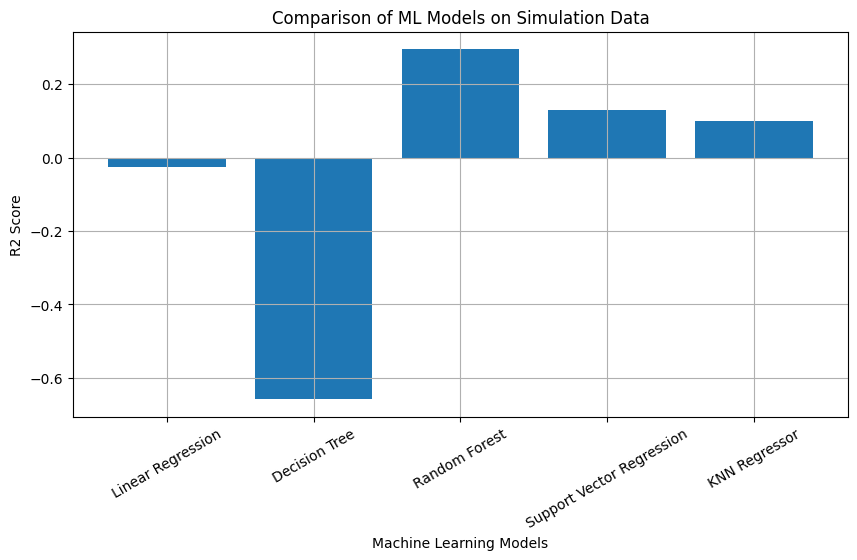

In [14]:
plt.figure(figsize=(10,5))
plt.bar(results_df["Model"], results_df["R2 Score"])
plt.xlabel("Machine Learning Models")
plt.ylabel("R2 Score")
plt.title("Comparison of ML Models on Simulation Data")
plt.xticks(rotation=30)
plt.grid(True)
plt.show()


In [15]:
best_model = results_df.sort_values(by="R2 Score", ascending=False).iloc[0]
best_model


,2
Model,Random Forest
Mean Squared Error,95.632188
R2 Score,0.29541
